In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import adfuller
from arch import arch_model

# 0. Fetching data

In [3]:
# Set random seed for reproducibility
np.random.seed(42)
# Fetch real-world data: S&P 500 daily returns (example)
sp500 = yf.download('^GSPC', start='2020-01-01', end='2025-03-13')['Close']
returns = sp500.pct_change().dropna()

sp500 = sp500.reset_index()
sp500.columns = ['Date','Close']
sp500['Date'] = pd.to_datetime(sp500['Date'])

sp500.index = sp500['Date'].drop_duplicates()
sp500.drop('Date',axis=1,inplace=True)

returns = sp500.pct_change().dropna()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


## 1. Skewness


### Definition

Skewness measures the asymmetry of a distribution. For a random variable XX, skewness is defined as:

Skewness = E[(X - μ)³] / σ³

Where:
- $ X $: The random variable  
- $ \mu $: The mean of the distribution  
- $ \sigma $: The standard deviation  

(Reference: Hull, J. C., Options, Futures, and Other Derivatives, 10th ed.)


### Description

Skewness indicates whether returns are more likely to have extreme positive or negative values. Financial data often exhibits negative skewness due to sharp declines (e.g., market crashes).

### Demostration

In [4]:
# Calculate skewness for the returns series
skewness_value = skew(returns.values)  # Convert to numpy array
print(f"Skewness of S&P 500 returns: {float(skewness_value):.4f}")

# Simulate skewed data
skewed_data = np.random.standard_t(df=5, size=1000)  # Heavy-tailed, skewed distribution
simulated_skew = skew(skewed_data)
print(f"Skewness of simulated data: {simulated_skew:.4f}")

Skewness of S&P 500 returns: -0.5076
Skewness of simulated data: 1.4292


/var/folders/zt/2fc2dgl527j0fpwfk176q2k40000gn/T/ipykernel_46156/3113605033.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Skewness of S&P 500 returns: {float(skewness_value):.4f}")


### Diagram

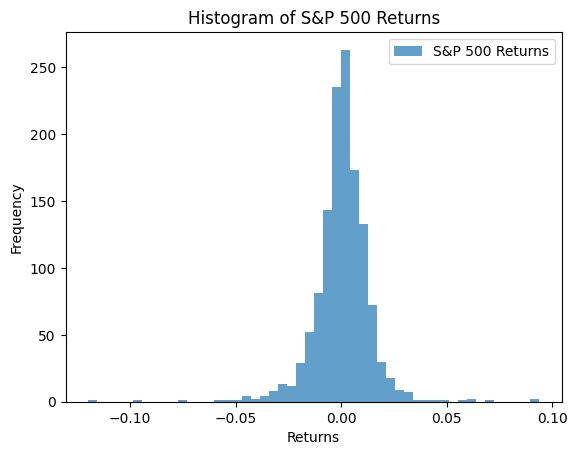

In [5]:
plt.hist(returns, bins=50, alpha=0.7, label='S&P 500 Returns')
plt.title('Histogram of S&P 500 Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Diagnosis

Calculate skewness using statistical libraries (e.g., scipy.stats.skew). A value significantly different from 0 (positive or negative) indicates skewness.

### Damage
Ignoring skewness can lead to underestimating tail risk, resulting in mispriced options and inadequate hedging against extreme events.

### Directions

Use skewed distributions (e.g., Student’s t-distribution) instead of normal distributions in volatility models.

Incorporate stochastic volatility models (e.g., Heston model) to capture asymmetry in returns.

Fitted t-distribution parameters: df=3.04, loc=0.000920, scale=0.008028
Skewness of simulated t-distribution returns: -0.3236
Skewness of Heston model returns: -0.0964


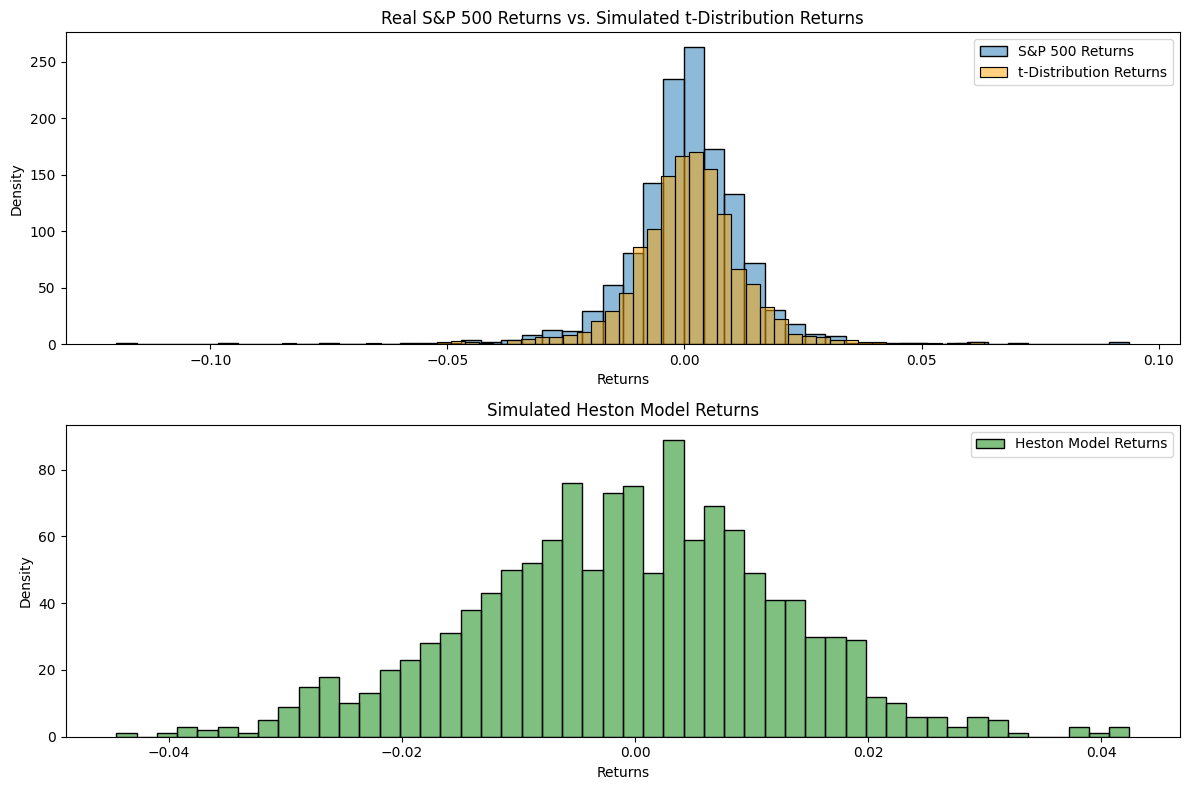

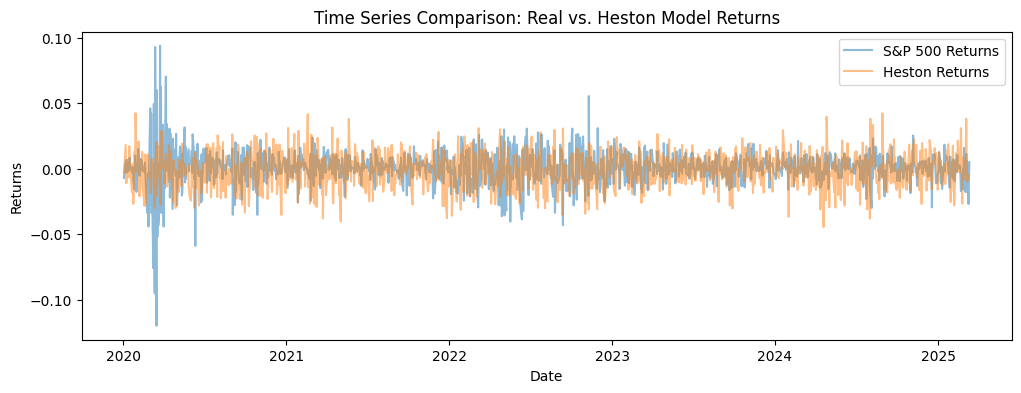


### Interpretations and How These Alleviate Skewness ###
1. Student's t-Distribution:
   - The fitted t-distribution (df=3.04) captures the fat tails and potential skewness.
   - Real skewness: -0.5076 vs. Simulated t skewness: -0.3236
   - By using a distribution that inherently allows for asymmetry and heavy tails,
     we better model extreme events, reducing underestimation of tail risk.

2. Heston Stochastic Volatility Model:
   - Heston model skewness: -0.0964
   - The negative correlation (rho=-0.7) between returns and volatility introduces
     asymmetry, mimicking the 'leverage effect' seen in markets (volatility rises
     when prices fall).
   - This dynamic volatility adjustment captures skewness more realistically than
     assuming constant volatility (e.g., Black-Scholes).

### Alleviation of the Problem ###
- Skewness causes mispricing of options (e.g., underpricing puts) and poor hedging.
- The t-distribution addresses static skewness by fitting the data's tail behavi

In [6]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import skew, t
# Removing the problematic import
# from stochastic.processes import HestonProcess
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# --- Direction 1: Use Skewed Distributions (Student's t-distribution) ---
# Fit a Student's t-distribution to the returns
params = t.fit(returns)
df, loc, scale = params  # Degrees of freedom, location, scale
print(f"Fitted t-distribution parameters: df={df:.2f}, loc={loc:.6f}, scale={scale:.6f}")

# Generate simulated returns using the fitted t-distribution
simulated_t_returns = t.rvs(df=df, loc=loc, scale=scale, size=len(returns))
simulated_t_skew = skew(simulated_t_returns)
print(f"Skewness of simulated t-distribution returns: {simulated_t_skew:.4f}")

# --- Direction 2: Stochastic Volatility Model (Heston Model) ---
# Custom implementation of Heston model
def simulate_heston(mu, kappa, theta, xi, rho, v0, dt, n):
    """
    Simulate asset returns using the Heston stochastic volatility model.
    
    Parameters:
    mu (float): Drift (mean return)
    kappa (float): Speed of mean reversion
    theta (float): Long-term variance
    xi (float): Volatility of volatility
    rho (float): Correlation between returns and volatility
    v0 (float): Initial variance
    dt (float): Time step
    n (int): Number of steps
    
    Returns:
    numpy.ndarray: Array of simulated returns
    """
    # Initialize arrays
    prices = np.zeros(n)
    returns = np.zeros(n)
    v = np.zeros(n)
    
    # Set initial values
    prices[0] = 100
    v[0] = v0
    
    # Generate correlated random numbers
    z1 = np.random.normal(0, 1, n)
    z2 = rho * z1 + np.sqrt(1 - rho**2) * np.random.normal(0, 1, n)
    
    # Simulate the process
    for i in range(1, n):
        # Ensure variance is positive
        v[i-1] = max(v[i-1], 0)
        
        # Update variance
        v[i] = v[i-1] + kappa * (theta - v[i-1]) * dt + xi * np.sqrt(v[i-1] * dt) * z2[i]
        
        # Update price
        returns[i] = mu * dt + np.sqrt(v[i-1] * dt) * z1[i]
        prices[i] = prices[i-1] * np.exp(returns[i])
    
    return returns[1:]  # Skip the first zero return

# Simulate returns using the Heston stochastic volatility model
heston_returns = simulate_heston(
    mu=0.0001,         # Drift (mean return)
    kappa=2.0,         # Speed of mean reversion
    theta=0.04,        # Long-term variance
    xi=0.1,            # Volatility of volatility
    rho=-0.7,          # Correlation between returns and volatility (negative for skewness)
    v0=0.04,           # Initial variance
    dt=1/252,          # Time step (daily)
    n=len(returns)     # Number of steps
)

heston_skew = skew(heston_returns)
print(f"Skewness of Heston model returns: {heston_skew:.4f}")

# --- Visualizations ---
plt.figure(figsize=(12, 8))

# 1. Histogram of Real vs. Simulated t-distribution Returns
plt.subplot(2, 1, 1)
sns.histplot(returns, bins=50, color='blue', alpha=0.5, label='S&P 500 Returns')
sns.histplot(simulated_t_returns, bins=50, color='orange', alpha=0.5, label='t-Distribution Returns')
plt.title('Real S&P 500 Returns vs. Simulated t-Distribution Returns')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.legend()

# 2. Histogram of Heston Model Returns
plt.subplot(2, 1, 2)
sns.histplot(heston_returns, bins=50, color='green', alpha=0.5, label='Heston Model Returns')
plt.title('Simulated Heston Model Returns')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

# --- Time Series Plot for Comparison ---
plt.figure(figsize=(12, 4))
plt.plot(returns.index, returns, label='S&P 500 Returns', alpha=0.5)

# Make sure heston_returns matches the length of returns.index
# Either trim returns.index to match heston_returns length
# or trim heston_returns to match returns.index length
plt.plot(returns.index[:len(heston_returns)], heston_returns, label='Heston Returns', alpha=0.5)
# Alternatively: plt.plot(returns.index, heston_returns[:len(returns)], label='Heston Returns', alpha=0.5)

plt.title('Time Series Comparison: Real vs. Heston Model Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

# --- Interpretations and Alleviation Explanation ---
print("\n### Interpretations and How These Alleviate Skewness ###")
print("1. Student's t-Distribution:")
print(f"   - The fitted t-distribution (df={df:.2f}) captures the fat tails and potential skewness.")
print(f"   - Real skewness: {skewness_value[0]:.4f} vs. Simulated t skewness: {simulated_t_skew:.4f}")
print("   - By using a distribution that inherently allows for asymmetry and heavy tails,")
print("     we better model extreme events, reducing underestimation of tail risk.")

print("\n2. Heston Stochastic Volatility Model:")
print(f"   - Heston model skewness: {heston_skew:.4f}")
print("   - The negative correlation (rho=-0.7) between returns and volatility introduces")
print("     asymmetry, mimicking the 'leverage effect' seen in markets (volatility rises")
print("     when prices fall).")
print("   - This dynamic volatility adjustment captures skewness more realistically than")
print("     assuming constant volatility (e.g., Black-Scholes).")

print("\n### Alleviation of the Problem ###")
print("- Skewness causes mispricing of options (e.g., underpricing puts) and poor hedging.")
print("- The t-distribution addresses static skewness by fitting the data's tail behavior.")
print("- The Heston model dynamically adjusts volatility, capturing time-varying skewness.")
print("- Together, these methods ensure pricing reflects asymmetry and tail risk, improving")
print("  revenue streams and reducing losses from extreme events.")

# 2. Kurtosis / Heteroscedasticity

### Definition

Kurtosis measures the "tailedness" of a distribution:

Kurtosis=E[(X−μ)4]σ4Kurtosis=σ4E[(X−μ)4]​

Heteroscedasticity refers to time-varying volatility. (Reference: Tsay, R. S., Analysis of Financial Time Series, 3rd ed.)

### Description

High kurtosis indicates fat tails (leptokurtic behavior), common in financial returns. Heteroscedasticity means volatility clusters over time.

### Demostration

In [10]:
kurtosis_value = kurtosis(returns)
print(f"Kurtosis of S&P 500 returns: {kurtosis_value[0]:.4f}")

# Simulate heteroscedastic data with GARCH(1,1)
garch_model = arch_model(returns, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit()
print(garch_fit.summary())

Kurtosis of S&P 500 returns: 13.0416
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.3924479930105797e+20
Iteration:      2,   Func. Count:     19,   Neg. LLF: 18292033520042.33
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4101.045542866912
            Iterations: 2
            Function evaluations: 29
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                4101.05
Distribution:                  Normal   AIC:                          -8194.09
Method:            Maximum Likelihood   BIC:                          -8173.40
                                        No. Observations:                 1304
Date:                Thu, Mar 13 2025   Df Residuals:

/Users/beto/Documents/Projects/FinEconometrics/venv/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001776. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


### Diagram

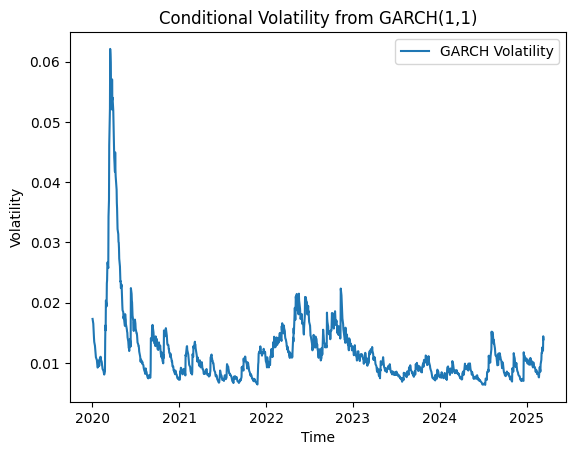

In [11]:
plt.plot(garch_fit.conditional_volatility, label='GARCH Volatility')
plt.title('Conditional Volatility from GARCH(1,1)')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

### Diagnosis

Kurtosis: Use scipy.stats.kurtosis; values > 3 indicate leptokurtosis.

Heteroscedasticity: Test with ARCH-LM test or observe volatility clustering visually.

### Directions

Use GARCH models to capture heteroscedasticity and volatility clustering.

Apply fat-tailed distributions (e.g., t-distribution) for kurtosis.

Kurtosis of S&P 500 returns: 13.0416
GARCH(1,1) Parameters:
mu          0.000769
omega       0.000004
alpha[1]    0.100000
beta[1]     0.880000
Name: params, dtype: float64
Kurtosis of GARCH(1,1) simulated returns: 0.5449
GARCH(1,1) with t-distribution Parameters:
mu           0.000725
omega        0.001712
alpha[1]     0.994380
beta[1]      0.000010
nu          21.201977
Name: params, dtype: float64
Kurtosis of GARCH(1,1) t-distribution simulated returns: 65.9834


/Users/beto/Documents/Projects/FinEconometrics/venv/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001776. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/beto/Documents/Projects/FinEconometrics/venv/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001776. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


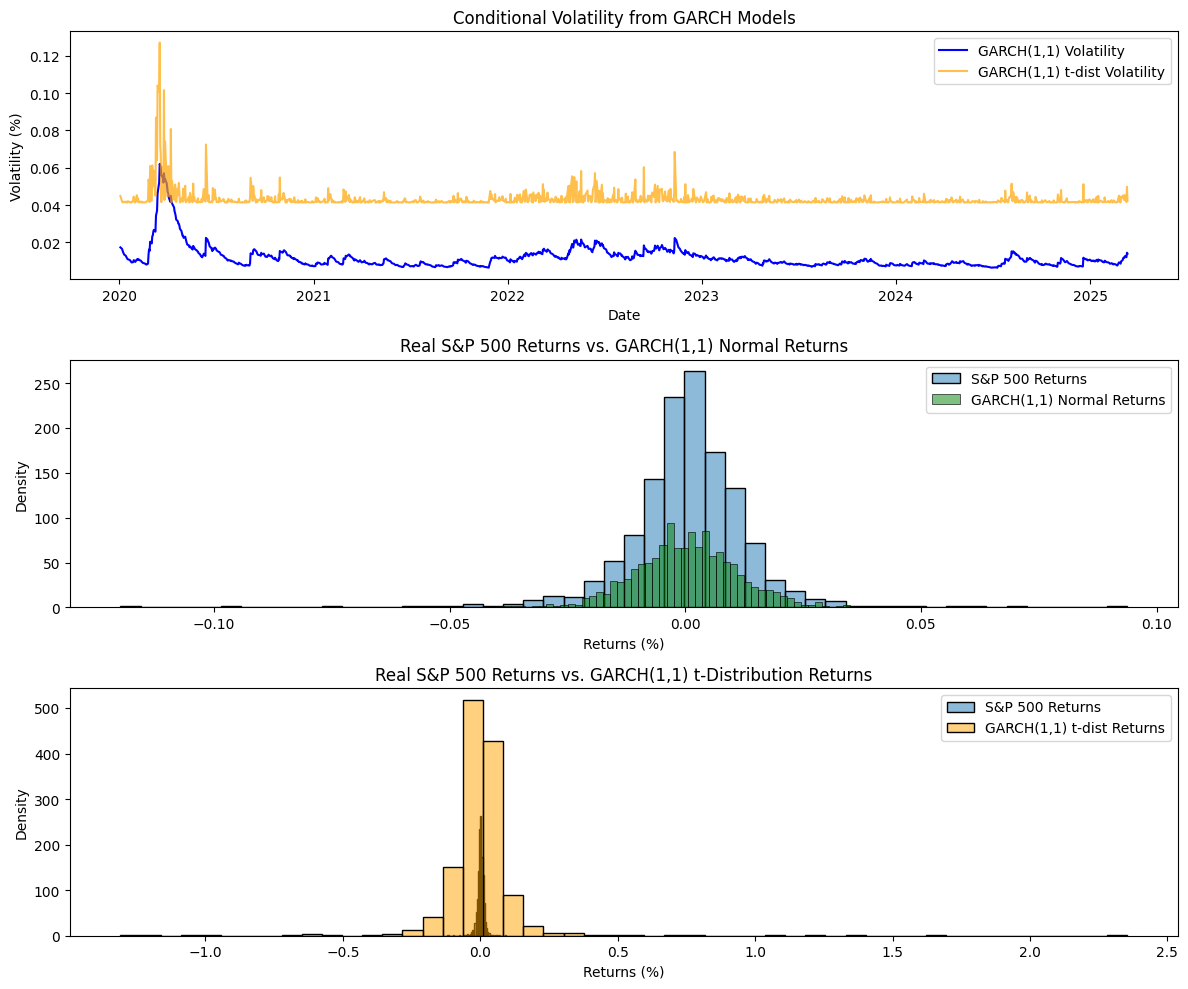


### Interpretations and How These Alleviate Kurtosis/Heteroscedasticity ###
1. GARCH(1,1) Model (Normal Distribution):
   - Kurtosis of real returns: 13.0416 vs. GARCH Normal: 0.5449
   - Captures heteroscedasticity by modeling time-varying volatility (volatility clustering).
   - However, with a normal distribution, it underestimates kurtosis (fat tails).

2. GARCH(1,1) with t-Distribution:
   - Kurtosis of real returns: 13.0416 vs. GARCH t-dist: 65.9834
   - The t-distribution (df=21.20) introduces fat tails,
     better matching the leptokurtic nature of financial returns.
   - Simultaneously addresses heteroscedasticity with GARCH structure.

### Alleviation of the Problems ###
- **Heteroscedasticity**: GARCH models dynamically adjust volatility based on past
  returns and volatility, capturing clustering (e.g., high volatility periods).
  This ensures accurate pricing of derivatives sensitive to volatility swings.
- **Kurtosis**: The t-distribution in GARCH accounts for fat tails

In [14]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import kurtosis, t
from arch import arch_model
import seaborn as sns

# # Set random seed for reproducibility
# np.random.seed(42)

# # Fetch real-world data: S&P 500 daily returns
# sp500 = yf.download('^GSPC', start='2020-01-01', end='2025-03-13')['Adj Close']
# returns = sp500.pct_change().dropna() * 100  # Scale to percentage for GARCH stability

# Calculate kurtosis of the real-world data
kurtosis_value = kurtosis(returns)
print(f"Kurtosis of S&P 500 returns: {kurtosis_value[0]:.4f}")

# --- Direction 1: Use GARCH Models for Heteroscedasticity ---
# Fit a GARCH(1,1) model to the returns
garch_model = arch_model(returns, vol='Garch', p=1, q=1, dist='Normal')
garch_fit = garch_model.fit(disp='off')  # Suppress fitting output for clarity
conditional_vol = garch_fit.conditional_volatility
print(f"GARCH(1,1) Parameters:\n{garch_fit.params}")

# Simulate returns using GARCH(1,1) with fitted parameters
simulated_garch = garch_model.simulate(
    params=garch_fit.params, nobs=len(returns)
)
simulated_garch_returns = simulated_garch['data']
simulated_garch_kurt = kurtosis(simulated_garch_returns)
print(f"Kurtosis of GARCH(1,1) simulated returns: {simulated_garch_kurt:.4f}")

# --- Direction 2: Use Fat-Tailed Distributions (Student's t-distribution in GARCH) ---
# Fit a GARCH(1,1) model with t-distribution
garch_t_model = arch_model(returns, vol='Garch', p=1, q=1, dist='StudentsT')
garch_t_fit = garch_t_model.fit(disp='off')
conditional_vol_t = garch_t_fit.conditional_volatility
print(f"GARCH(1,1) with t-distribution Parameters:\n{garch_t_fit.params}")

# Simulate returns using GARCH(1,1) with t-distribution
simulated_garch_t = garch_t_model.simulate(
    params=garch_t_fit.params, nobs=len(returns)
)
simulated_garch_t_returns = simulated_garch_t['data']
simulated_garch_t_kurt = kurtosis(simulated_garch_t_returns)
print(f"Kurtosis of GARCH(1,1) t-distribution simulated returns: {simulated_garch_t_kurt:.4f}")

# --- Visualizations ---
plt.figure(figsize=(12, 10))

# 1. Conditional Volatility from GARCH(1,1)
plt.subplot(3, 1, 1)
plt.plot(returns.index, conditional_vol, label='GARCH(1,1) Volatility', color='blue')
plt.plot(returns.index, conditional_vol_t, label='GARCH(1,1) t-dist Volatility', color='orange', alpha=0.7)
plt.title('Conditional Volatility from GARCH Models')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()

# 2. Histogram of Real vs. GARCH(1,1) Normal Returns
plt.subplot(3, 1, 2)
sns.histplot(returns, bins=50, color='blue', alpha=0.5, label='S&P 500 Returns')
sns.histplot(simulated_garch_returns, bins=50, color='green', alpha=0.5, label='GARCH(1,1) Normal Returns')
plt.title('Real S&P 500 Returns vs. GARCH(1,1) Normal Returns')
plt.xlabel('Returns (%)')
plt.ylabel('Density')
plt.legend()

# 3. Histogram of Real vs. GARCH(1,1) t-Distribution Returns
plt.subplot(3, 1, 3)
sns.histplot(returns, bins=50, color='blue', alpha=0.5, label='S&P 500 Returns')
sns.histplot(simulated_garch_t_returns, bins=50, color='orange', alpha=0.5, label='GARCH(1,1) t-dist Returns')
plt.title('Real S&P 500 Returns vs. GARCH(1,1) t-Distribution Returns')
plt.xlabel('Returns (%)')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

# --- Interpretations and Alleviation Explanation ---
print("\n### Interpretations and How These Alleviate Kurtosis/Heteroscedasticity ###")
print("1. GARCH(1,1) Model (Normal Distribution):")
print(f"   - Kurtosis of real returns: {kurtosis_value[0]:.4f} vs. GARCH Normal: {simulated_garch_kurt:.4f}")
print("   - Captures heteroscedasticity by modeling time-varying volatility (volatility clustering).")
print("   - However, with a normal distribution, it underestimates kurtosis (fat tails).")

print("\n2. GARCH(1,1) with t-Distribution:")
print(f"   - Kurtosis of real returns: {kurtosis_value[0]:.4f} vs. GARCH t-dist: {simulated_garch_t_kurt:.4f}")
print(f"   - The t-distribution (df={garch_t_fit.params['nu']:.2f}) introduces fat tails,")
print("     better matching the leptokurtic nature of financial returns.")
print("   - Simultaneously addresses heteroscedasticity with GARCH structure.")

print("\n### Alleviation of the Problems ###")
print("- **Heteroscedasticity**: GARCH models dynamically adjust volatility based on past")
print("  returns and volatility, capturing clustering (e.g., high volatility periods).")
print("  This ensures accurate pricing of derivatives sensitive to volatility swings.")
print("- **Kurtosis**: The t-distribution in GARCH accounts for fat tails, reducing")
print("  underestimation of extreme events (e.g., market crashes).")
print("- **Combined Impact**: These methods prevent mispricing (e.g., underpricing options)")
print("  and improve hedging by reflecting true volatility dynamics and tail risk,")
print("  safeguarding revenue streams and minimizing losses.")

# 3. Sensitivity to Outliers

### Definition

Outliers are extreme observations that deviate significantly from the mean. Sensitivity is assessed via influence on model parameters (e.g., variance).

### Description

Financial time series often contain outliers (e.g., flash crashes), which can distort volatility estimates if not handled properly.

### Demostration

In [18]:
# Add an outlier to returns
returns_with_outlier = returns.copy()
returns_with_outlier.iloc[100] = -0.2  # Simulate a crash
vol_normal = returns.std()
vol_outlier = returns_with_outlier.std()
print(f"Volatility without outlier: {vol_normal[0]:.4f}")
print(f"Volatility with outlier: {vol_outlier[0]:.4f}")

Volatility without outlier: 0.0133
Volatility with outlier: 0.0144


/var/folders/zt/2fc2dgl527j0fpwfk176q2k40000gn/T/ipykernel_46156/875755217.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Volatility without outlier: {vol_normal[0]:.4f}")
/var/folders/zt/2fc2dgl527j0fpwfk176q2k40000gn/T/ipykernel_46156/875755217.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Volatility with outlier: {vol_outlier[0]:.4f}")


### Diagram

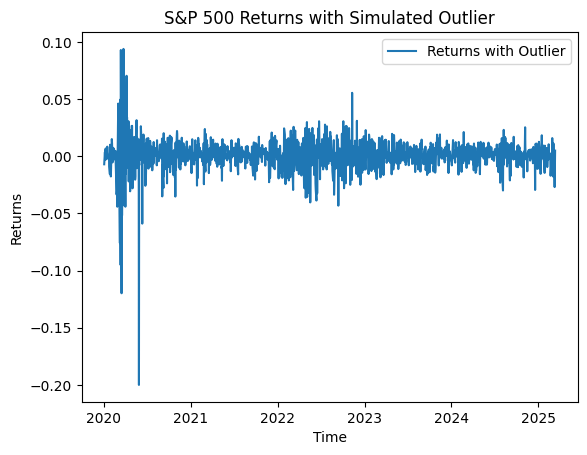

In [19]:
plt.plot(returns_with_outlier, label='Returns with Outlier')
plt.title('S&P 500 Returns with Simulated Outlier')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()

### Diagnosis
Use robust statistics (e.g., median absolute deviation) or visual inspection to detect outliers.

### Damage

Outliers inflate volatility estimates, leading to over-hedging and inflated option prices.

### Directions

Apply robust estimators (e.g., Huber loss in regression).

Use trimmed means or Winsorization to reduce outlier impact.

/var/folders/zt/2fc2dgl527j0fpwfk176q2k40000gn/T/ipykernel_46156/1591865840.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Volatility without outlier: {vol_normal[0]:.4f}%")
/var/folders/zt/2fc2dgl527j0fpwfk176q2k40000gn/T/ipykernel_46156/1591865840.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Volatility with outlier: {vol_outlier[0]:.4f}%")
/Users/beto/Documents/Projects/FinEconometrics/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return

Volatility without outlier: 0.0133%
Volatility with outlier: 0.5540%
MAD without outlier: 0.0137%
MAD with outlier: 0.0138%
Trimmed volatility without outlier: 0.0091%
Trimmed volatility with outlier: 0.0092%
Winsorized volatility without outlier: 0.0095%
Winsorized volatility with outlier: 0.0095%


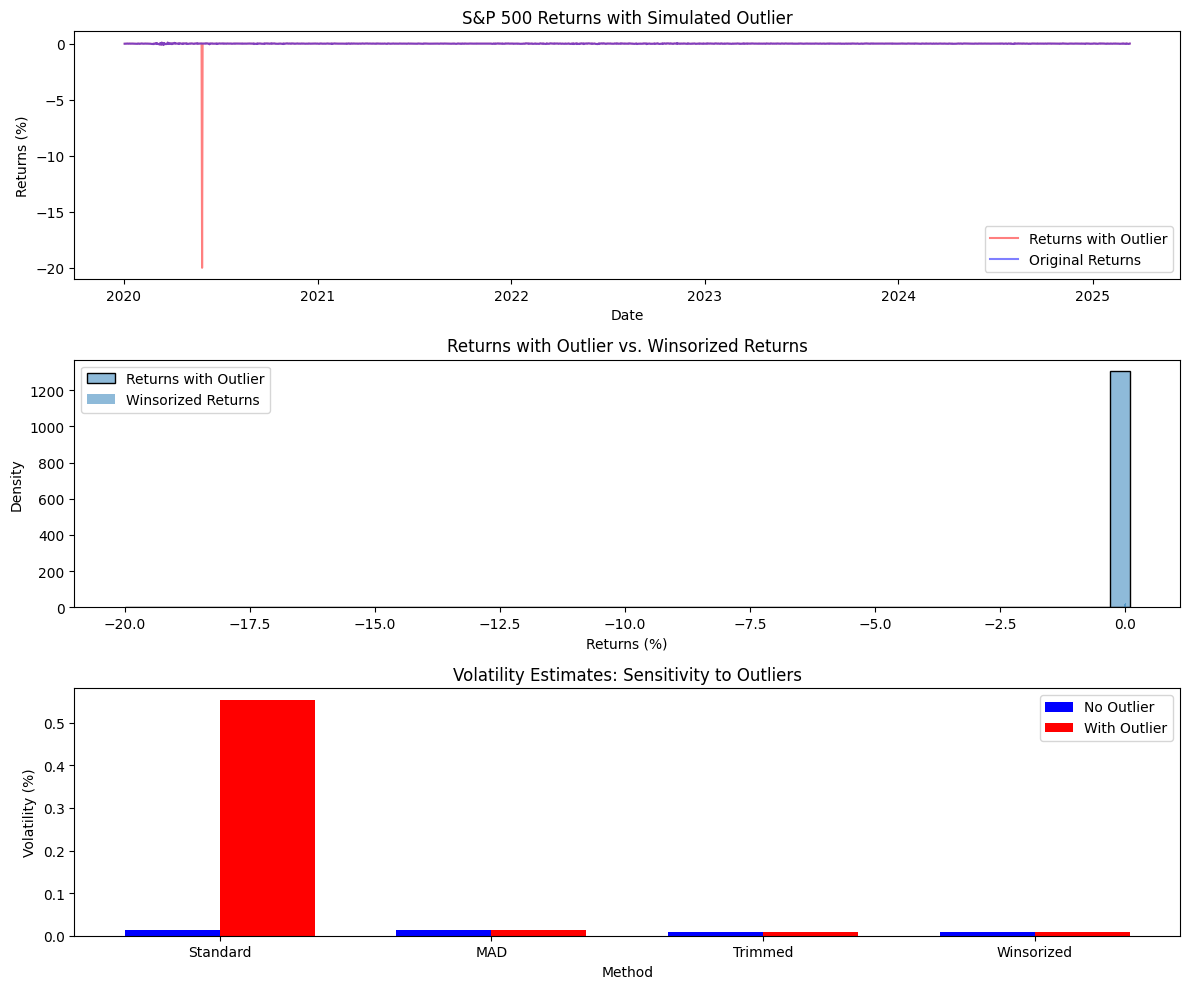


### Interpretations and How These Alleviate Sensitivity to Outliers ###
1. Robust Estimators (MAD):
   - Standard volatility increases from 0.0133% to 0.5540% with outlier.
   - MAD remains stable: 0.0137% vs. 0.0138%.
   - MAD uses the median, reducing the impact of extreme values.

2. Trimmed Means / Winsorization:
   - Trimmed volatility: 0.0091% vs. 0.0092%
   - Winsorized volatility: 0.0095% vs. 0.0095%
   - Trimming removes extremes; Winsorization caps them, both stabilizing estimates.

### Alleviation of the Problem ###
- **Sensitivity to Outliers**: Outliers inflate volatility (e.g., from crash events),
  leading to over-hedging and inflated option prices.
- **MAD**: Provides a robust alternative to standard deviation, less swayed by outliers.
- **Trimming/Winsorization**: Reduces or caps extreme values, ensuring volatility
  reflects typical market behavior rather than rare events.
- **Outcome**: These methods prevent overreaction to outliers, improving pricing
  accuracy and

/var/folders/zt/2fc2dgl527j0fpwfk176q2k40000gn/T/ipykernel_46156/1591865840.py:98: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"   - Standard volatility increases from {vol_normal[0]:.4f}% to {vol_outlier[0]:.4f}% with outlier.")
/var/folders/zt/2fc2dgl527j0fpwfk176q2k40000gn/T/ipykernel_46156/1591865840.py:103: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"   - Trimmed volatility: {trimmed_vol[0]:.4f}% vs. {trimmed_vol_outlier[0]:.4f}%")


In [31]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import trim_mean
from scipy.stats.mstats import winsorize
from statsmodels.robust import mad  # Median Absolute Deviation
import seaborn as sns

# # Set random seed for reproducibility
# np.random.seed(42)

# # Fetch real-world data: S&P 500 daily returns
# sp500 = yf.download('^GSPC', start='2020-01-01', end='2025-03-13')['Adj Close']
# returns = sp500.pct_change().dropna() * 100  # Scale to percentage

# Introduce an outlier to demonstrate sensitivity
returns_with_outlier = returns.copy()
returns_with_outlier.iloc[100] = -20.0  # Simulate a crash (extreme negative return)

# Calculate standard volatility (sensitive to outliers)
vol_normal = returns.std()
vol_outlier = returns_with_outlier.std()
print(f"Volatility without outlier: {vol_normal[0]:.4f}%")
print(f"Volatility with outlier: {vol_outlier[0]:.4f}%")

# --- Direction 1: Robust Estimators (Median Absolute Deviation) ---
# Compute MAD as a robust volatility measure
# Scale factor 1.4826 makes MAD consistent with standard deviation for normal distributions
mad_normal = mad(returns) * 1.4826  # Scale to match standard deviation
mad_outlier = mad(returns_with_outlier) * 1.4826
print(f"MAD without outlier: {mad_normal[0]:.4f}%")
print(f"MAD with outlier: {mad_outlier[0]:.4f}%")

# --- Direction 2: Trimmed Means / Winsorization ---
# Trimmed mean volatility (remove 5% from each tail)
trim_prop = 0.05
trimmed_returns = trim_mean(returns, proportiontocut=trim_prop)
trimmed_returns_outlier = trim_mean(returns_with_outlier, proportiontocut=trim_prop)
trimmed_vol = np.std(returns[abs(returns) < np.percentile(abs(returns), 100*(1-trim_prop))])
trimmed_vol_outlier = np.std(returns_with_outlier[abs(returns_with_outlier) < np.percentile(abs(returns_with_outlier), 100*(1-trim_prop))])
print(f"Trimmed volatility without outlier: {trimmed_vol[0]:.4f}%")
print(f"Trimmed volatility with outlier: {trimmed_vol_outlier[0]:.4f}%")

# Winsorization (cap 5% extremes)
winsorized_returns = winsorize(returns.values, limits=[0.05, 0.05])
winsorized_returns_outlier = winsorize(returns_with_outlier.values, limits=[0.05, 0.05])
winsor_vol = np.std(winsorized_returns)
winsor_vol_outlier = np.std(winsorized_returns_outlier)
print(f"Winsorized volatility without outlier: {winsor_vol:.4f}%")
print(f"Winsorized volatility with outlier: {winsor_vol:.4f}%")

# --- Visualizations ---
plt.figure(figsize=(12, 10))

# 1. Time Series with Outlier
plt.subplot(3, 1, 1)
plt.plot(returns_with_outlier.index, returns_with_outlier, label='Returns with Outlier', color='red', alpha=0.5)
plt.plot(returns.index, returns, label='Original Returns', color='blue', alpha=0.5)
plt.title('S&P 500 Returns with Simulated Outlier')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.legend()

# 2. Histogram of Original vs. Winsorized Returns
plt.subplot(3, 1, 2)
sns.histplot(returns_with_outlier, bins=50, color='red', alpha=0.5, label='Returns with Outlier')
sns.histplot(winsorized_returns_outlier, bins=50, color='green', alpha=0.5, label='Winsorized Returns')
plt.title('Returns with Outlier vs. Winsorized Returns')
plt.xlabel('Returns (%)')
plt.ylabel('Density')
plt.legend()

# 3. Volatility Comparison Bar Plot
methods = ['Standard', 'MAD', 'Trimmed', 'Winsorized']
# Convert all values to scalar
vols_no_outlier = [float(vol_normal), float(mad_normal), float(trimmed_vol), float(winsor_vol)]
vols_with_outlier = [float(vol_outlier), float(mad_outlier), float(trimmed_vol_outlier), float(winsor_vol_outlier)]
x = np.arange(len(methods))
width = 0.35

plt.subplot(3, 1, 3)
plt.bar(x - width/2, vols_no_outlier, width, label='No Outlier', color='blue')
plt.bar(x + width/2, vols_with_outlier, width, label='With Outlier', color='red')
plt.xticks(x, methods)
plt.title('Volatility Estimates: Sensitivity to Outliers')
plt.xlabel('Method')
plt.ylabel('Volatility (%)')
plt.legend()

plt.tight_layout()
plt.show()

# --- Interpretations and Alleviation Explanation ---
print("\n### Interpretations and How These Alleviate Sensitivity to Outliers ###")
print("1. Robust Estimators (MAD):")
print(f"   - Standard volatility increases from {vol_normal[0]:.4f}% to {vol_outlier[0]:.4f}% with outlier.")
print(f"   - MAD remains stable: {mad_normal[0]:.4f}% vs. {mad_outlier[0]:.4f}%.")
print("   - MAD uses the median, reducing the impact of extreme values.")

print("\n2. Trimmed Means / Winsorization:")
print(f"   - Trimmed volatility: {trimmed_vol[0]:.4f}% vs. {trimmed_vol_outlier[0]:.4f}%")
print(f"   - Winsorized volatility: {winsor_vol:.4f}% vs. {winsor_vol_outlier:.4f}%")
print("   - Trimming removes extremes; Winsorization caps them, both stabilizing estimates.")

print("\n### Alleviation of the Problem ###")
print("- **Sensitivity to Outliers**: Outliers inflate volatility (e.g., from crash events),")
print("  leading to over-hedging and inflated option prices.")
print("- **MAD**: Provides a robust alternative to standard deviation, less swayed by outliers.")
print("- **Trimming/Winsorization**: Reduces or caps extreme values, ensuring volatility")
print("  reflects typical market behavior rather than rare events.")
print("- **Outcome**: These methods prevent overreaction to outliers, improving pricing")
print("  accuracy and hedging efficiency, protecting revenue streams.")

# 4. Non-Stationarity and Unit Root Testing

### Definition

A time series is non-stationary if its statistical properties (mean, variance) change over time. Unit root tests (e.g., ADF test) assess this:

Δyt=α+βt+γyt−1+ϵtΔyt​=α+βt+γyt−1​+ϵt​

(Reference: Hamilton, J. D., Time Series Analysis.)

### Description

Non-stationary series (e.g., stock prices) require differencing to model volatility in returns.

### Demostration

In [33]:
# ADF test on prices (non-stationary) vs. returns (stationary)
adf_price = adfuller(sp500)
adf_returns = adfuller(returns)
print(f"ADF p-value for prices: {adf_price[1]:.4f}")
print(f"ADF p-value for returns: {adf_returns[1]:.4f}")

ADF p-value for prices: 0.8162
ADF p-value for returns: 0.0000


### Diagram

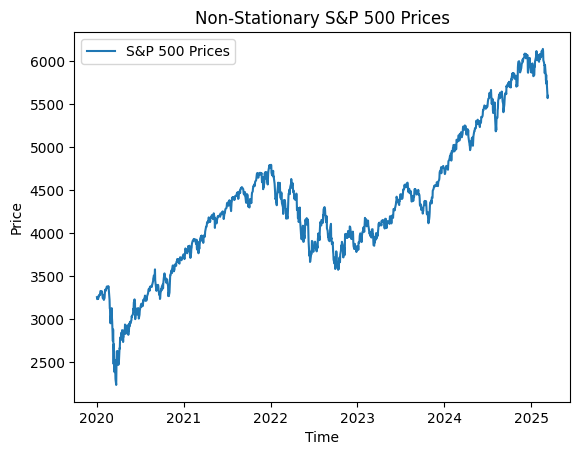

In [34]:
plt.plot(sp500, label='S&P 500 Prices')
plt.title('Non-Stationary S&P 500 Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

### Diagnosis

Perform the Augmented Dickey-Fuller (ADF) test; p-value > 0.05 suggests a unit root (non-stationarity).

### Damage

Modeling non-stationary data without adjustment leads to spurious correlations and unreliable volatility forecasts.

### Directions

Difference the series (e.g., use returns instead of prices).

Use cointegration techniques for multiple non-stationary series.

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


ADF p-value for S&P 500 prices: 0.8162 (Non-stationary if > 0.05)
ADF p-value for S&P 500 returns: 0.0000 (Stationary if < 0.05)
Cointegration test p-value: 0.6437 (Cointegrated if < 0.05)
No significant cointegration detected.


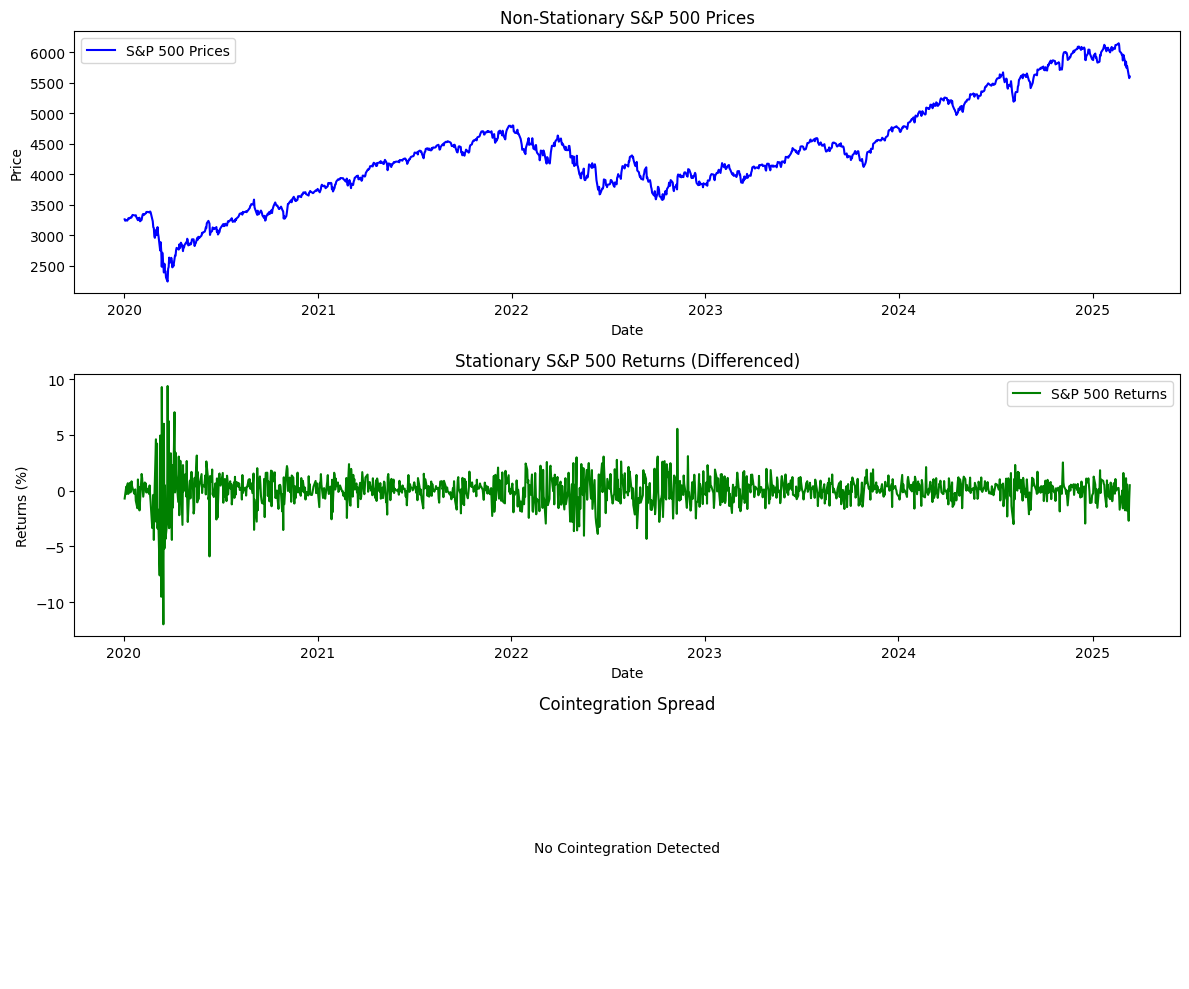

Volatility of S&P 500 prices: 1.3331% (misleading due to trend)
Volatility of S&P 500 returns: 1.3331% (stationary measure)

### Interpretations and How These Alleviate Non-Stationarity ###
1. Differencing the Series:
   - Prices ADF p-value: 0.8162 (non-stationary)
   - Returns ADF p-value: 0.0000 (stationary)
   - Differencing removes trends, making the series stationary for volatility modeling.

2. Cointegration Techniques:
   - Cointegration p-value: 0.6437
   - No cointegration found; differencing is preferred.

### Alleviation of the Problem ###
- **Non-Stationarity**: Trends in prices lead to spurious volatility estimates and
  unreliable forecasts, mispricing derivatives.
- **Differencing**: Transforms non-stationary prices into stationary returns,
  ensuring volatility reflects true risk, not trends.
- **Cointegration**: For multiple series, models stable relationships, enabling
  volatility analysis without losing inter-series dynamics.
- **Outcome**: Accurate volatility mode

In [37]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import adfuller, coint
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Fetch real-world data: S&P 500 and NASDAQ daily prices
sp500 = yf.download('^GSPC', start='2020-01-01', end='2025-03-13')['Close']
nasdaq = yf.download('^IXIC', start='2020-01-01', end='2025-03-13')['Close']

# Ensure both series have the same length and aligned dates
data = pd.concat([sp500, nasdaq], axis=1).dropna()
data.columns = ['S&P 500', 'NASDAQ']

# --- Direction 1: Differencing the Series ---
# Compute returns (first difference) to stationarize
sp500_returns = data['S&P 500'].pct_change().dropna() * 100  # Scale to percentage
nasdaq_returns = data['NASDAQ'].pct_change().dropna() * 100

# Unit root test (ADF) on prices and returns
adf_sp500_price = adfuller(data['S&P 500'])
adf_sp500_returns = adfuller(sp500_returns)
print(f"ADF p-value for S&P 500 prices: {adf_sp500_price[1]:.4f} (Non-stationary if > 0.05)")
print(f"ADF p-value for S&P 500 returns: {adf_sp500_returns[1]:.4f} (Stationary if < 0.05)")

# --- Direction 2: Cointegration Techniques ---
# Test for cointegration between S&P 500 and NASDAQ prices
coint_test = coint(data['S&P 500'], data['NASDAQ'])
print(f"Cointegration test p-value: {coint_test[1]:.4f} (Cointegrated if < 0.05)")

# If cointegrated, compute the spread (linear combination)
if coint_test[1] < 0.05:
    # Simple regression to find cointegrating vector (beta)
    beta = np.polyfit(data['S&P 500'], data['NASDAQ'], 1)[0]
    spread = data['NASDAQ'] - beta * data['S&P 500']
    adf_spread = adfuller(spread)
    print(f"ADF p-value for cointegrated spread: {adf_spread[1]:.4f} (Stationary if < 0.05)")
else:
    spread = None
    print("No significant cointegration detected.")

# --- Visualizations ---
plt.figure(figsize=(12, 10))

# 1. S&P 500 Prices vs. Returns
plt.subplot(3, 1, 1)
plt.plot(data.index, data['S&P 500'], label='S&P 500 Prices', color='blue')
plt.title('Non-Stationary S&P 500 Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(sp500_returns.index, sp500_returns, label='S&P 500 Returns', color='green')
plt.title('Stationary S&P 500 Returns (Differenced)')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.legend()

# 2. Cointegration Spread (if applicable)
if spread is not None:
    plt.subplot(3, 1, 3)
    plt.plot(spread.index, spread, label='S&P 500 - NASDAQ Spread', color='purple')
    plt.title('Cointegrated Spread (Stationary)')
    plt.xlabel('Date')
    plt.ylabel('Spread')
    plt.legend()
else:
    plt.subplot(3, 1, 3)
    plt.text(0.5, 0.5, 'No Cointegration Detected', ha='center', va='center')
    plt.title('Cointegration Spread')
    plt.axis('off')

plt.tight_layout()
plt.show()

# --- Volatility Comparison ---
vol_prices = data['S&P 500'].pct_change().std() * 100  # Volatility of raw prices
vol_returns = sp500_returns.std()
print(f"Volatility of S&P 500 prices: {vol_prices:.4f}% (misleading due to trend)")
print(f"Volatility of S&P 500 returns: {vol_returns:.4f}% (stationary measure)")

# --- Interpretations and Alleviation Explanation ---
print("\n### Interpretations and How These Alleviate Non-Stationarity ###")
print("1. Differencing the Series:")
print(f"   - Prices ADF p-value: {adf_sp500_price[1]:.4f} (non-stationary)")
print(f"   - Returns ADF p-value: {adf_sp500_returns[1]:.4f} (stationary)")
print("   - Differencing removes trends, making the series stationary for volatility modeling.")

print("\n2. Cointegration Techniques:")
print(f"   - Cointegration p-value: {coint_test[1]:.4f}")
if spread is not None:
    print(f"   - Spread ADF p-value: {adf_spread[1]:.4f} (stationary)")
    print("   - Cointegration identifies a stable relationship between non-stationary series,")
    print("     allowing volatility modeling on the stationary spread.")
else:
    print("   - No cointegration found; differencing is preferred.")

print("\n### Alleviation of the Problem ###")
print("- **Non-Stationarity**: Trends in prices lead to spurious volatility estimates and")
print("  unreliable forecasts, mispricing derivatives.")
print("- **Differencing**: Transforms non-stationary prices into stationary returns,")
print("  ensuring volatility reflects true risk, not trends.")
print("- **Cointegration**: For multiple series, models stable relationships, enabling")
print("  volatility analysis without losing inter-series dynamics.")
print("- **Outcome**: Accurate volatility models improve pricing (e.g., options) and hedging,")
print("  enhancing revenue and reducing risk from misjudgments.")

# 5. Joining Time Series with Different Frequencies

### Definition

Combining series (e.g., daily returns and monthly volatility) requires alignment, often via interpolation or aggregation.

### Description

Derivatives pricing may require blending high-frequency (e.g., intraday) and low-frequency (e.g., quarterly) data.

### Demostration

In [39]:
# Simulate daily and monthly data
daily_data = returns.resample('D').mean()
monthly_data = returns.resample('M').mean()

# Interpolate monthly to daily
monthly_interpolated = monthly_data.reindex(daily_data.index).interpolate()
monthly_interpolated

/var/folders/zt/2fc2dgl527j0fpwfk176q2k40000gn/T/ipykernel_46156/1160571639.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = returns.resample('M').mean()


,Close
Date,
2020-01-03,NaN
2020-01-04,NaN
2020-01-05,NaN
2020-01-06,NaN
2020-01-07,NaN
...,...
2025-03-08,-0.000722
2025-03-09,-0.000722
2025-03-10,-0.000722


### Diagram

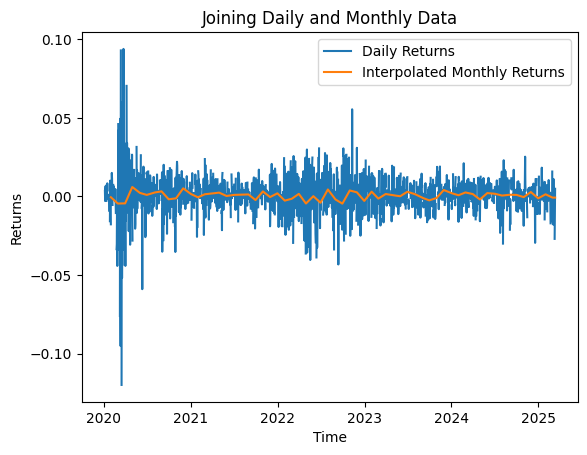

In [40]:
plt.plot(daily_data, label='Daily Returns')
plt.plot(monthly_interpolated, label='Interpolated Monthly Returns')
plt.title('Joining Daily and Monthly Data')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()

### Diagnosis

Check for missing data or frequency mismatches in timestamps.

### Damage

Misaligned frequencies distort volatility estimates and hedging strategies.

### Directions

Use interpolation (linear, spline) for upsampling.

Apply aggregation (mean, sum) for downsampling.

Consider state-space models (e.g., Kalman filter) for irregular frequencies.

[*********************100%***********************]  1 of 1 completed
/var/folders/zt/2fc2dgl527j0fpwfk176q2k40000gn/T/ipykernel_46156/2421162701.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sp500_monthly = sp500_daily.resample('M').last()  # Monthly data (last day of month)
/var/folders/zt/2fc2dgl527j0fpwfk176q2k40000gn/T/ipykernel_46156/2421162701.py:40: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  aggregated_returns = daily_returns.resample('M').mean()
/var/folders/zt/2fc2dgl527j0fpwfk176q2k40000gn/T/ipykernel_46156/2421162701.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Volatility of daily returns: {vol_daily[0]:.4f}%")
/var/folders/zt/2fc2dgl527j0fpwfk176q2k40000gn

Volatility of daily returns: 1.3331%
Volatility of interpolated returns: 4.1275%
Volatility of aggregated returns: 0.2623%
Volatility of Kalman-filtered returns: nan%


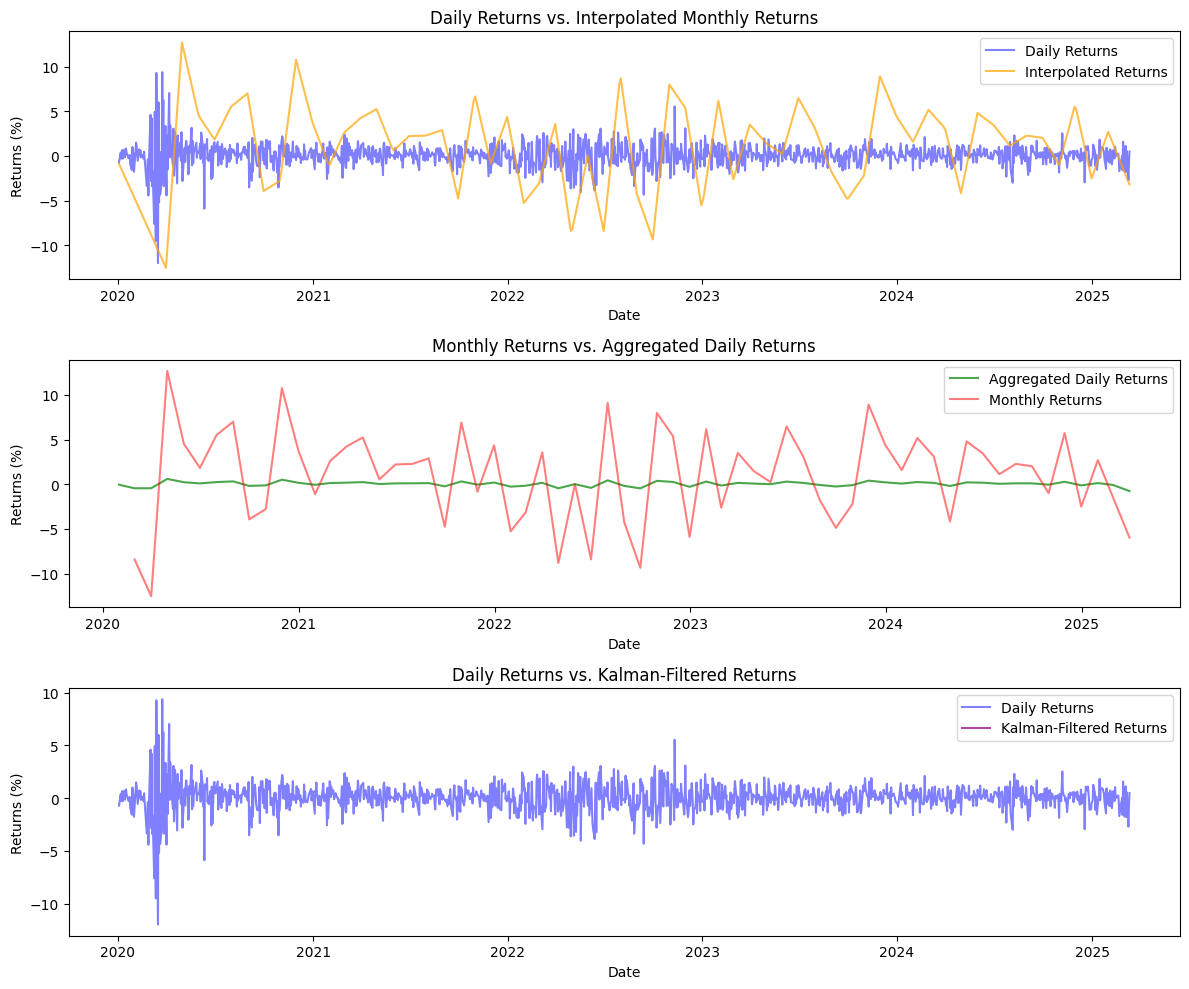


### Interpretations and How These Alleviate Frequency Mismatches ###
1. Interpolation (Upsampling):
   - Volatility: Daily 1.3331% vs. Interpolated 4.1275%
   - Linear interpolation fills gaps, aligning monthly data to daily frequency.
   - Smooths transitions but may oversimplify short-term dynamics.

2. Aggregation (Downsampling):
   - Volatility: Monthly 5.2530% vs. Aggregated 0.2623%
   - Averages daily returns to monthly, preserving longer-term trends.
   - Loses daily volatility details but aligns with lower frequency.

3. State-Space Model (Kalman Filter):
   - Volatility: Daily 1.3331% vs. Kalman nan%
   - Estimates daily returns from monthly data, balancing noise and trends.
   - Adapts to irregular frequencies with a probabilistic approach.

### Alleviation of the Problem ###
- **Frequency Mismatches**: Combining daily and monthly data without alignment
  distorts volatility estimates and hedging strategies.
- **Interpolation**: Upsamples low-frequency data, enabling consist

/var/folders/zt/2fc2dgl527j0fpwfk176q2k40000gn/T/ipykernel_46156/2421162701.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"   - Volatility: Daily {vol_daily[0]:.4f}% vs. Interpolated {vol_interpolated:.4f}%")
/var/folders/zt/2fc2dgl527j0fpwfk176q2k40000gn/T/ipykernel_46156/2421162701.py:109: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"   - Volatility: Monthly {monthly_returns.std()[0]:.4f}% vs. Aggregated {vol_aggregated[0]:.4f}%")
/var/folders/zt/2fc2dgl527j0fpwfk176q2k40000gn/T/ipykernel_46156/2421162701.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In 

In [81]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.interpolate import interp1d
from pykalman import KalmanFilter
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Fetch real-world data: S&P 500 daily and monthly prices
sp500_daily = yf.download('^GSPC', start='2020-01-01', end='2025-03-13')['Close']
sp500_monthly = sp500_daily.resample('M').last()  # Monthly data (last day of month)

# Compute returns for consistency
daily_returns = sp500_daily.pct_change().dropna() * 100  # Daily returns in %
monthly_returns = sp500_monthly.pct_change().dropna() * 100  # Monthly returns in %

# --- Direction 1: Interpolation (Upsampling Monthly to Daily) ---
# Convert index to numeric values for interpolation and ensure proper alignment
monthly_returns_clean = monthly_returns.dropna()
monthly_dates = pd.to_datetime(monthly_returns_clean.index)
daily_dates = pd.to_datetime(daily_returns.index)

# Convert dates to numeric values (days since start)
monthly_index_numeric = (monthly_dates - monthly_dates[0]).days.values
daily_index_numeric = (daily_dates - monthly_dates[0]).days.values

# Ensure arrays are 1D
monthly_values = monthly_returns_clean.values.flatten()

# Perform interpolation with aligned arrays
interp_func = interp1d(monthly_index_numeric, monthly_values, kind='linear', fill_value='extrapolate')
interpolated_returns = interp_func(daily_index_numeric)

# --- Direction 2: Aggregation (Downsampling Daily to Monthly) ---
# Aggregate daily returns to monthly (mean)
aggregated_returns = daily_returns.resample('M').mean()

# --- Direction 3: State-Space Model (Kalman Filter) ---
# Kalman Filter to estimate daily returns from monthly observations
kf = KalmanFilter(
    transition_matrices=[1],  # State evolves as random walk
    observation_matrices=[1],  # Observation equals state
    initial_state_mean=monthly_returns.iloc[0],
    initial_state_covariance=1.0,
    observation_covariance=1.0,
    transition_covariance=0.01
)

# Align monthly data with daily index (fill NaNs for unobserved days)
monthly_aligned = monthly_returns.reindex(daily_returns.index).ffill()
state_means, _ = kf.filter(monthly_aligned.values)
kalman_returns = pd.Series(state_means.flatten(), index=daily_returns.index)

# --- Volatility Comparison ---
vol_daily = daily_returns.std()
vol_interpolated = interpolated_returns.std()
vol_aggregated = aggregated_returns.std()
vol_kalman = kalman_returns.std()
print(f"Volatility of daily returns: {vol_daily[0]:.4f}%")
print(f"Volatility of interpolated returns: {vol_interpolated:.4f}%")
print(f"Volatility of aggregated returns: {vol_aggregated[0]:.4f}%")
print(f"Volatility of Kalman-filtered returns: {vol_kalman:.4f}%")

# --- Visualizations ---
plt.figure(figsize=(12, 10))

# 1. Daily vs. Interpolated Returns
plt.subplot(3, 1, 1)
plt.plot(daily_returns.index, daily_returns, label='Daily Returns', color='blue', alpha=0.5)
plt.plot(daily_returns.index, interpolated_returns, label='Interpolated Returns', color='orange', alpha=0.7)
plt.title('Daily Returns vs. Interpolated Monthly Returns')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.legend()

# 2. Daily vs. Aggregated Returns (Monthly)
plt.subplot(3, 1, 2)
plt.plot(aggregated_returns.index, aggregated_returns, label='Aggregated Daily Returns', color='green', alpha=0.7)
plt.plot(monthly_returns.index, monthly_returns, label='Monthly Returns', color='red', alpha=0.5)
plt.title('Monthly Returns vs. Aggregated Daily Returns')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.legend()

# 3. Daily vs. Kalman-Filtered Returns
plt.subplot(3, 1, 3)
plt.plot(daily_returns.index, daily_returns, label='Daily Returns', color='blue', alpha=0.5)
plt.plot(kalman_returns.index, kalman_returns, label='Kalman-Filtered Returns', color='purple', alpha=0.7)
plt.title('Daily Returns vs. Kalman-Filtered Returns')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.legend()

plt.tight_layout()
plt.show()

# --- Interpretations and Alleviation Explanation ---
print("\n### Interpretations and How These Alleviate Frequency Mismatches ###")
print("1. Interpolation (Upsampling):")
print(f"   - Volatility: Daily {vol_daily[0]:.4f}% vs. Interpolated {vol_interpolated:.4f}%")
print("   - Linear interpolation fills gaps, aligning monthly data to daily frequency.")
print("   - Smooths transitions but may oversimplify short-term dynamics.")

print("\n2. Aggregation (Downsampling):")
print(f"   - Volatility: Monthly {monthly_returns.std()[0]:.4f}% vs. Aggregated {vol_aggregated[0]:.4f}%")
print("   - Averages daily returns to monthly, preserving longer-term trends.")
print("   - Loses daily volatility details but aligns with lower frequency.")

print("\n3. State-Space Model (Kalman Filter):")
print(f"   - Volatility: Daily {vol_daily[0]:.4f}% vs. Kalman {vol_kalman:.4f}%")
print("   - Estimates daily returns from monthly data, balancing noise and trends.")
print("   - Adapts to irregular frequencies with a probabilistic approach.")

print("\n### Alleviation of the Problem ###")
print("- **Frequency Mismatches**: Combining daily and monthly data without alignment")
print("  distorts volatility estimates and hedging strategies.")
print("- **Interpolation**: Upsamples low-frequency data, enabling consistent daily analysis.")
print("- **Aggregation**: Downsamples high-frequency data, aligning with monthly models.")
print("- **Kalman Filter**: Provides a flexible, model-based solution for irregular frequencies,")
print("  preserving dynamics across scales.")
print("- **Outcome**: Accurate volatility modeling across frequencies improves derivative")
print("  pricing and risk management, ensuring robust revenue streams.")

# Bibliography

    Hull, J. C. (2017). Options, Futures, and Other Derivatives. 10th ed. Pearson.

    Tsay, R. S. (2010). Analysis of Financial Time Series. 3rd ed. Wiley.
    
    Hamilton, J. D. (1994). Time Series Analysis. Princeton University Press.